In [ ]:
!pip install torch==2.2.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install transformers seqeval numpy==1.26.4 matplotlib
import json, re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification
from seqeval.metrics import f1_score, classification_report
import matplotlib.pyplot as plt



Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
from google.colab import files
uploaded = files.upload()   # upload train_redacted.jsonl




Saving train_redacted.jsonl to train_redacted.jsonl


In [3]:

!wget https://raw.githubusercontent.com/hide-ous/semeval26_task10_starter_pack/main/rehydrate_data.py


--2025-12-07 13:40:33--  https://raw.githubusercontent.com/hide-ous/semeval26_task10_starter_pack/main/rehydrate_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5355 (5.2K) [text/plain]
Saving to: ‘rehydrate_data.py’

rehydrate_data.py   100%[===================>]   5.23K  --.-KB/s    in 0s      

2025-12-07 13:40:33 (56.7 MB/s) - ‘rehydrate_data.py’ saved [5355/5355]



In [4]:
!python rehydrate_data.py \
    --input train_redacted.jsonl \
    --output train_rehydrated.jsonl

/content/rehydrate_data.py:29: SyntaxWarning: invalid escape sequence '\W'
  return re.sub("http(.+)?(\W|$)", url_replacement_token, x)
Rehydrating comments:   0% 0/9 [00:00<?, ?it/s]/content/rehydrate_data.py:23: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ' '.join(soup.findAll(string=True))
Rehydrating comments:  11% 1/9 [00:00<00:07,  1.00it/s]Warning: Could not rehydrate comment with id 't1_ewekgmh'
Rehydrating comments:  22% 2/9 [00:01<00:06,  1.05it/s]Warning: Could not rehydrate comment with id 't1_euna7wh'
Rehydrating comments:  33% 3/9 [00:02<00:04,  1.21it/s]Warning: Could not rehydrate comment with id 't1_f7yvawr'
Rehydrating comments:  44% 4/9 [00:03<00:04,  1.12it/s]Warning: Could not rehydrate comment with id 't1_fdhnr97'
Rehydrating comments:  56% 5/9 [00:04<00:03,  1.13it/s]Warning: Could not rehydrate comment with id 't1_ewtwg9o'
Rehydrating comments:  67% 6/9 [00:05<00:02,  1.13it/s]Warning:

In [5]:
def clean_text_safe(text):

    text = text.lower()

    # Replace fancy unicode quotes with ASCII
    text = text.replace("’", "'").replace("“", '"').replace("”", '"')

    return text

data = []
with open("train_rehydrated.jsonl") as f:
    for line in f:
        item = json.loads(line)
        item["text"] = clean_text_safe(item["text"])
        data.append(item)

print("Loaded:", len(data), "examples")


Loaded: 4316 examples


In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 128

# Collect all labels
all_tags = set()
for item in data:
    for m in item.get("markers", []):
        all_tags.add("B-" + m["type"])
        all_tags.add("I-" + m["type"])
all_tags.add("O")

tag2id = {t:i for i,t in enumerate(sorted(all_tags))}
id2tag = {i:t for t,i in tag2id.items()}

def tokenize_and_align_labels(item):
    text = item["text"]
    labels = ["O"] * len(text)

    for m in item.get("markers", []):
        start, end = m["startIndex"], m["endIndex"]
        labels[start] = "B-" + m["type"]
        for i in range(start+1, end):
            labels[i] = "I-" + m["type"]

    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_offsets_mapping=True
    )

    word_labels = []
    for start, end in encoding["offset_mapping"]:
        if start == end:
            word_labels.append(tag2id["O"])
        else:
            word_labels.append(tag2id[labels[start]])

    encoding.pop("offset_mapping")
    encoding["labels"] = word_labels
    return encoding


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
class NERDataset(Dataset):
    def __init__(self, data):
        self.encodings = [tokenize_and_align_labels(item) for item in data]

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        item = self.encodings[idx]
        return {k: torch.tensor(v) for k,v in item.items()}

train_dataset = NERDataset(data)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [ ]:
# BERT model for token classification
# The model will be initialized using AutoModelForTokenClassification
# No custom class needed - using pre-trained BERT with a classification head


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize BERT model for token classification
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(tag2id),
    id2label=id2tag,
    label2id=tag2id
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_history = []

for epoch in range(7):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")


Epoch 1 Loss: 0.7500
Epoch 2 Loss: 0.6596
Epoch 3 Loss: 0.6133
Epoch 4 Loss: 0.5577
Epoch 5 Loss: 0.4873
Epoch 6 Loss: 0.4108
Epoch 7 Loss: 0.3445


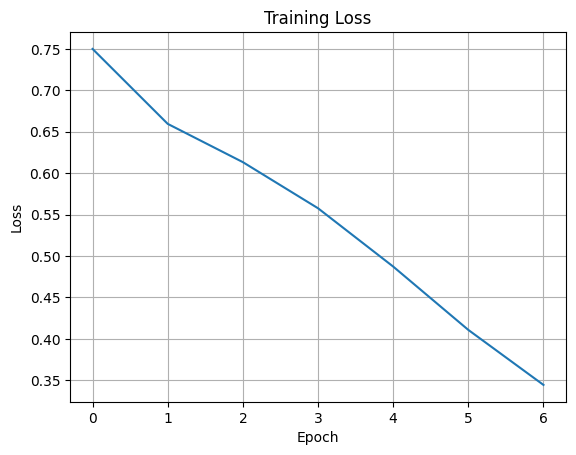

In [10]:
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [11]:
def get_spans(pred_seq, id2tag):
    spans, start, label = [], None, None
    for i, tag_id in enumerate(pred_seq):
        tag = id2tag[tag_id]
        if tag.startswith("B-"):
            if start is not None:
                spans.append((start, i, label))
            start, label = i, tag[2:]
        elif tag.startswith("I-") and start is not None:
            continue
        else:
            if start is not None:
                spans.append((start, i, label))
                start = None
    if start is not None:
        spans.append((start, len(pred_seq), label))
    return spans


In [ ]:
all_preds_spans, all_labels_spans = [], []

model.eval()
with torch.no_grad():
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(-1).cpu()

        for i in range(preds.shape[0]):
            length = (batch["attention_mask"][i] != 0).sum().item()

            pred_seq = preds[i].tolist()[:length]
            label_seq = labels[i].tolist()[:length]

            all_preds_spans.append(get_spans(pred_seq, id2tag))
            all_labels_spans.append(get_spans(label_seq, id2tag))


In [13]:
def overlap_f1(pred_spans, true_spans):
    TP = FP = FN = 0

    for p, t in zip(pred_spans, true_spans):
        matched = set()
        for ps in p:
            found = False
            for i, ts in enumerate(t):
                if ps[2] == ts[2]:  # label
                    if not (ps[1] <= ts[0] or ps[0] >= ts[1]):  # overlap
                        TP += 1
                        matched.add(i)
                        found = True
                        break
            if not found:
                FP += 1
        FN += len(t) - len(matched)

    prec = TP / (TP + FP + 1e-8)
    rec = TP / (TP + FN + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    return prec, rec, f1

precision, recall, f1 = overlap_f1(all_preds_spans, all_labels_spans)
print("Overlap Precision:", precision)
print("Overlap Recall:", recall)
print("Overlap F1:", f1)


Overlap Precision: 0.7841109709952281
Overlap Recall: 0.2994317634593569
Overlap F1: 0.43337050060007226


In [16]:

def overlap_f1_per_class(pred_spans, true_spans):
    marker_types = ['Actor', 'Action', 'Effect', 'Victim', 'Evidence']
    results = {}

    for m_type in marker_types:
        TP = FP = FN = 0

        for p, t in zip(pred_spans, true_spans):
            matched = set()
            # Check predicted spans of this type
            for ps in p:
                if ps[2] == m_type:
                    found = False
                    for i, ts in enumerate(t):
                        if ts[2] == m_type:
                            if not (ps[1] <= ts[0] or ps[0] >= ts[1]):
                                TP += 1
                                matched.add(i)
                                found = True
                                break
                    if not found:
                        FP += 1

            # Count false negatives for this type
            for i, ts in enumerate(t):
                if ts[2] == m_type and i not in matched:
                    FN += 1

        prec = TP / (TP + FP + 1e-8)
        rec = TP / (TP + FN + 1e-8)
        f1 = 2 * prec * rec / (prec + rec + 1e-8) if (prec + rec) > 0 else 0

        results[m_type] = {'precision': prec, 'recall': rec, 'f1': f1, 'tp': TP, 'fp': FP, 'fn': FN}

    return results

# Calculate per-class metrics
per_class_results = overlap_f1_per_class(all_preds_spans, all_labels_spans)
print("\nPer-class Overlap F1 Scores:")
for marker, scores in per_class_results.items():
    print(f"{marker}: P={scores['precision']:.3f}, R={scores['recall']:.3f}, F1={scores['f1']:.3f}")


Per-class Overlap F1 Scores:
Actor: P=0.785, R=0.460, F1=0.580
Action: P=0.810, R=0.316, F1=0.455
Effect: P=0.817, R=0.182, F1=0.297
Victim: P=0.718, R=0.228, F1=0.346
Evidence: P=0.771, R=0.182, F1=0.295


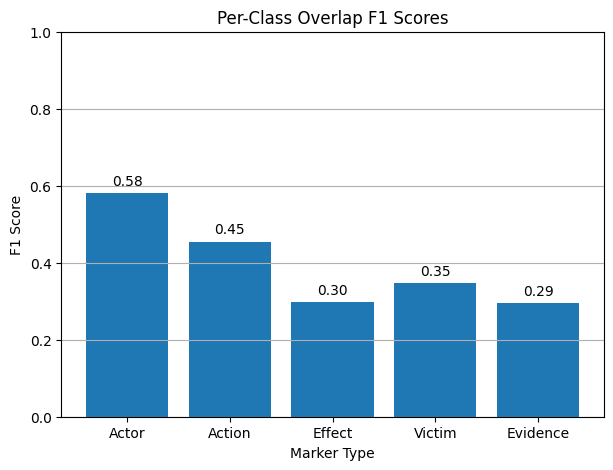

In [17]:
#   Plot Per-Class Overlap F1

import matplotlib.pyplot as plt

marker_types = list(per_class_results.keys())
f1_scores = [per_class_results[m]['f1'] for m in marker_types]

plt.figure(figsize=(7,5))
plt.bar(marker_types, f1_scores)
plt.title("Per-Class Overlap F1 Scores")
plt.xlabel("Marker Type")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y')

for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.show()


In [18]:

torch.save({
    'model_state_dict': model.state_dict(),
    'tag2id': tag2id,
    'id2tag': id2tag,
    'tokenizer': tokenizer,
}, 'subtask1_baseline_model.pt')

print("Model saved")

Model saved
